In [2]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import regularizers
from keras.layers import Dense 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
file_path = 'E:/Coding/Projects/Titanic survive prediction/Data file/'
train = pd.read_csv(file_path+'train.csv')
test = pd.read_csv(file_path+'test.csv')
data = pd.concat([train,test]).reset_index()

In [5]:
## there are NaN values in ['Age','Cabin','Embarked', 'Fare']

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        1309 non-null   int64  
 1   PassengerId  1309 non-null   int64  
 2   Survived     891 non-null    float64
 3   Pclass       1309 non-null   int64  
 4   Name         1309 non-null   object 
 5   Sex          1309 non-null   object 
 6   Age          1046 non-null   float64
 7   SibSp        1309 non-null   int64  
 8   Parch        1309 non-null   int64  
 9   Ticket       1309 non-null   object 
 10  Fare         1308 non-null   float64
 11  Cabin        295 non-null    object 
 12  Embarked     1307 non-null   object 
dtypes: float64(3), int64(5), object(5)
memory usage: 133.1+ KB


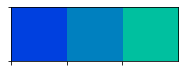

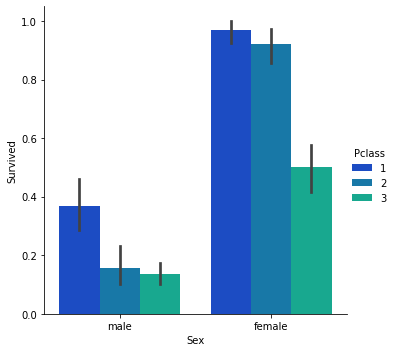

In [10]:
## visualize the relation between sex, Pclass and suvival rate

current_palette = sns.color_palette('winter',3)
sns.palplot(current_palette)
sns.catplot(x='Sex',y='Survived',hue='Pclass',kind='bar',data=data, palette=current_palette)

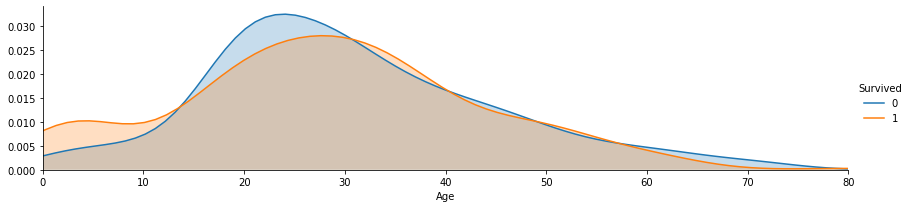

In [8]:
## visualize the distribution of the Age data

facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

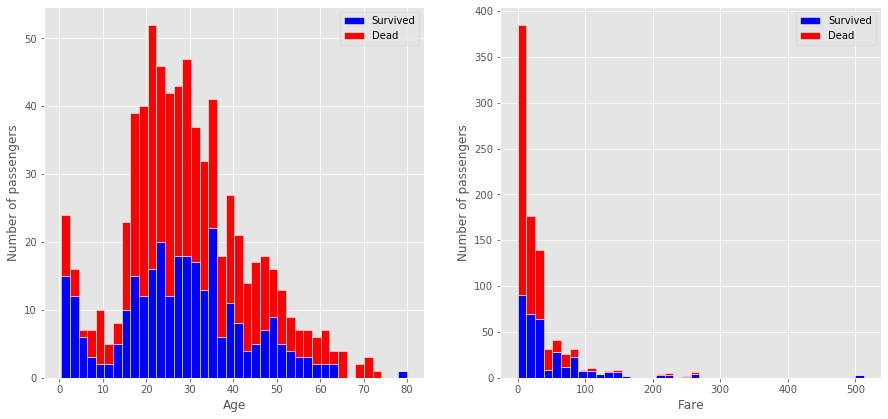

In [61]:
## visualize the portions of survived and dead people according to Age and Fare 

fig=plt.figure(figsize=(15,15))
plt.style.use('ggplot')
plt.subplot(221)
pic=plt.hist([data[data['Survived'] == 1]['Age'],  data[data['Survived'] == 0]['Age']], 
             stacked=True,bins =40, label=['Survived','Dead'], 
             edgecolor='white',color = ['b','r'])

plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()

plt.subplot(222)
plt.hist([data[data['Survived'] == 1]['Fare'],data[data['Survived'] == 0]['Fare']], 
         stacked=True, color = ['b','r'],bins = 40,
         label = ['Survived','Dead'],edgecolor='white')

plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

---------------------------------------------------------------


<font size=10>Feature engineering</font>


---------------------------------------------------------

In [11]:
## combine Parch and SibSp data 

data['family_size'] = data['Parch'] + data['SibSp'] + 1

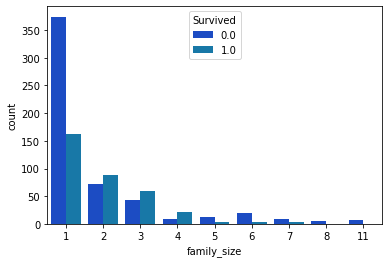

In [13]:
## it seems that family_size dosen't have infulence on survival rate

sns.countplot(data['family_size'],hue=data['Survived'], palette=current_palette)

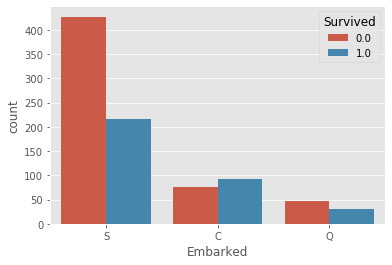

In [64]:
## S has the highest survival rate 

sns.countplot(data['Embarked'],hue=data['Survived'])

In [14]:
## expand: expand the splitted strings into separate columns.

data['Title_temp'] = data['Name'].str.split(', ',expand=True)[1]
data['Title_temp'] = data['Title_temp'].str.split('.',expand=True)[0]
data['Title_temp'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [17]:
## define a crosstab to see the number of survived people for each title

title_survived=pd.crosstab(data['Title_temp'],data['Sex']).T

In [18]:
cm=sns.light_palette('blue',as_cmap=True)
title_survived.style.background_gradient(cmap=cm)

Title_temp,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,,
female,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1
male,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0


In [19]:
## the average age for each title

data.groupby(['Title_temp'])['Age'].mean()

Title_temp
Capt            70.000000
Col             54.000000
Don             40.000000
Dona            39.000000
Dr              43.571429
Jonkheer        38.000000
Lady            48.000000
Major           48.500000
Master           5.482642
Miss            21.774238
Mlle            24.000000
Mme             24.000000
Mr              32.252151
Mrs             36.994118
Ms              28.000000
Rev             41.250000
Sir             49.000000
the Countess    33.000000
Name: Age, dtype: float64

In [21]:
## replace the unfrequent title with ['Mr','Mrs','Miss']

data['Title'] = data['Title_temp'].replace(['Capt','Col','Don','Dr','Jonkheer','Major','Rev','Sir','Dona'
                                     ,'Lady','Mlle','Mme','Ms','the Countess'],
                                    ['Mr','Mr','Mr','Mr','Mr','Mr','Mr','Mr','Mrs','Mrs','Miss','Miss','Miss','Mrs'])

In [22]:
data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

In [71]:
## fill NaN value of Embarked with 'S'

data['Embarked'] = data['Embarked'].fillna(train['Embarked'].value_counts().idxmax())

In [72]:
## fill NaN values of Fare with mean

data['Fare'] = data['Fare'].fillna(data['Fare'][:891].mean())

In [74]:
## I tried to fill NaN values of Age with the mean value according to each Title, but get worse acc

# age_median = data['Age'][:891].groupby(data['Title'][:891]).median()
# data.loc[(data['Age'].isna()) & (data['Title'] == 'Master'),'Age']=data.loc[(data['Age'].isna())&(data['Title'] == 'Master'),'Age'].fillna(age_median['Master'])
# data.loc[(data['Age'].isna()) & (data['Title'] == 'Mr'),'Age']=data.loc[(data['Age'].isna())& (data['Title'] == 'Mr'),'Age'].fillna(age_median['Mr'])
# data.loc[(data['Age'].isna()) & (data['Title'] == 'Mrs'),'Age']=data.loc[(data['Age'].isna())& (data['Title'] == 'Mrs'),'Age'].fillna(age_median['Mrs'])
# data.loc[(data['Age'].isna()) & (data['Title'] == 'Miss'),'Age']=data.loc[(data['Age'].isna())& (data['Title'] == 'Miss'),'Age'].fillna(age_median['Miss'])

In [23]:
## fill NaN values of Age with the mean according to the groups of title and Pclass

obj = data['Age'][:891].groupby([data['Title'],data['Pclass']])
data['Age'][:891] = obj.transform(lambda x: x.fillna(x.mean()))
obj_1 = data['Age'][891:].groupby([data['Title'],data['Pclass']])
data['Age'][891:] = obj_1.transform(lambda x: x.fillna(x.mean()))

C:\Users\Y.Liu\Anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Y.Liu\Anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
data.Cabin=data.Cabin.fillna('U')

In [25]:
## use the first character of Cabin to present Cabin info

data.Cabin=data.Cabin.map(lambda cabin:cabin[0] )

In [27]:
## filter the people who have the same ticket number

same_tickets=[]
for ticket in data.Ticket.unique():
    same_ticket=data.loc[data.Ticket == ticket,'Fare']
    if same_ticket.count() > 1:
        same_tickets.append(data.loc[data.Ticket == ticket, ['Ticket','Name','Fare','family_size','Cabin']])

In [28]:
df_same_tickets=pd.concat(same_tickets)

In [29]:
df_same_tickets.head(20)

,Ticket,Name,Fare,family_size,Cabin
1,PC 17599,"Cumings, Mrs. John Bradley (Florence Briggs Th...",71.2833,2,C
1125,PC 17599,"Cumings, Mr. John Bradley",71.2833,2,C
3,113803,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",53.1000,2,C
137,113803,"Futrelle, Mr. Jacques Heath",53.1000,2,C
6,17463,"McCarthy, Mr. Timothy J",51.8625,1,E
1037,17463,"Hilliard, Mr. Herbert Henry",51.8625,1,E
7,349909,"Palsson, Master. Gosta Leonard",21.0750,5,U
24,349909,"Palsson, Miss. Torborg Danira",21.0750,5,U
374,349909,"Palsson, Miss. Stina Viola",21.0750,5,U
567,349909,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",21.0750,5,U


In [86]:
## create a new feature 'relative_survived' based on the people who have the same ticket number
## relative_survived = 0.5 : people who have no relation with others
## relative_survived = 0 or 1 : people who have relation with others

df_ticket=data.groupby('Ticket')
data['relative_survived']=0.5
for _,tk in df_ticket:
    if len(tk)>1:
        for ind, row in tk.iterrows():
            smax = tk.drop(ind)['Survived'].max()
            smin = tk.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data.loc[data['PassengerId'] == passID, 'relative_survived'] = 1
            elif (smin==0.0):
                data.loc[data['PassengerId'] == passID, 'relative_survived'] = 0
                
                
print("people who have relation : %.0f" %(data[data['relative_survived']!=0.5].shape[0]))

people who have relation : 496


In [87]:
## get dummy variables for Embarked, Sex, Title and Pclass 

embarked_dummy = pd.get_dummies(data['Embarked'],prefix='Embarked')
data = pd.concat([data,embarked_dummy],axis=1)

data.Sex = data['Sex'].map({'male':0,'female':1})

title_dummy = pd.get_dummies(data['Title'],prefix='Title')
data = pd.concat([data,title_dummy],axis=1)

Pclass_dummy = pd.get_dummies(data['Pclass'],prefix='Pclass')
data = pd.concat([data,Pclass_dummy],axis=1)

In [99]:
## Normalization

norm = StandardScaler()
data['Fare'] = norm.fit_transform(data['Fare'].values.reshape(-1,1))

In [100]:
## get the log value of Age

data['Age'] = np.log(data['Age'])
#data['Age'] = norm.fit_transform(data['Age'].values.reshape(-1,1))

In [101]:
## drop the useless feature

df = data.drop(columns=['family_size','PassengerId','Name','Parch','Survived','index','Embarked','Pclass','SibSp','Ticket','Cabin','Title_temp','Title'])

In [102]:
df

,Age,Fare,Sex,relative_survived,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Pclass_1,Pclass_2,Pclass_3
0,3.091042,-0.503579,0,0.5,0,0,1,0,0,1,0,0,0,1
1,3.637586,0.734519,1,0.5,1,0,0,0,0,0,1,1,0,0
2,3.258097,-0.490527,1,0.5,0,0,1,0,1,0,0,0,0,1
3,3.555348,0.382941,1,0.0,0,0,1,0,0,0,1,1,0,0
4,3.555348,-0.488110,0,0.5,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3.303173,-0.488110,0,0.5,0,0,1,0,0,1,0,0,0,1
1305,3.663562,1.461845,1,1.0,1,0,0,0,0,0,1,1,0,0
1306,3.650658,-0.503579,0,0.5,0,0,1,0,0,1,0,0,0,1
1307,3.303173,-0.488110,0,0.5,0,0,1,0,0,1,0,0,0,1


In [103]:
## split the data 

X = df[:891]
y = data['Survived'][:891]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30,random_state=44)

In [140]:
## define the model: I use the ANN with batch normalization 

def build_model(X_train = X_train,neurons=4,optimizer='Adam',layer=1):
    
    model = models.Sequential()
    model.add(Dense(X_train.shape[1], kernel_regularizer=regularizers.l2(0.001), 
                           activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.BatchNormalization())
    
    for i in range(layer):
        model.add(layers.Dense(neurons,  kernel_regularizer=regularizers.l2(0.001), activation='relu'))
        model.add(layers.BatchNormalization())
        
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

In [141]:
## early_stopping and GridSearch

early_stopping = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
grid_model = KerasClassifier(build_fn=build_model, verbose=1)

batch_size=[128]
layer=[1,2]
epochs=[100]
neurons= [6,8,10]
param_grid = dict(neurons=neurons, epochs=epochs,layer=layer,batch_size=batch_size)


grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, cv=5, verbose=1)  

grid_history = grid.fit(X_train, y_train, validation_data=(X_val, y_val))




Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 498 samples, validate on 268 samples
Epoch 1/100
498/498 [==============================] - 0s 854us/step - loss: 0.6076 - accuracy: 0.7189 - val_loss: 0.6254 - val_accuracy: 0.6642
Epoch 2/100
498/498 [==============================] - 0s 80us/step - loss: 0.5746 - accuracy: 0.7510 - val_loss: 0.6161 - val_accuracy: 0.6754
Epoch 3/100
498/498 [==============================] - 0s 78us/step - loss: 0.5591 - accuracy: 0.7671 - val_loss: 0.6077 - val_accuracy: 0.7313
Epoch 4/100
498/498 [==============================] - 0s 78us/step - loss: 0.5395 - accuracy: 0.7530 - val_loss: 0.6000 - val_accuracy: 0.7388
Epoch 5/100
498/498 [==============================] - 0s 76us/step - loss: 0.5230 - accuracy: 0.7470 - val_loss: 0.5922 - val_accuracy: 0.7463
Epoch 6/100
498/498 [==============================] - 0s 78us/step - loss: 0.5014 - accuracy: 0.7610 - val_loss: 0.5848 - val_accuracy: 0.7612
Epoch 7/100
498/498 [==============================] - 0s 74us/step - loss: 0.4949 - accu

Epoch 13/100
498/498 [==============================] - 0s 76us/step - loss: 0.5713 - accuracy: 0.7811 - val_loss: 0.6712 - val_accuracy: 0.6866
Epoch 14/100
498/498 [==============================] - 0s 76us/step - loss: 0.5605 - accuracy: 0.7912 - val_loss: 0.6671 - val_accuracy: 0.6866
Epoch 15/100
498/498 [==============================] - 0s 74us/step - loss: 0.5503 - accuracy: 0.7791 - val_loss: 0.6626 - val_accuracy: 0.6940
Epoch 16/100
498/498 [==============================] - 0s 76us/step - loss: 0.5453 - accuracy: 0.7851 - val_loss: 0.6582 - val_accuracy: 0.6940
Epoch 17/100
498/498 [==============================] - 0s 78us/step - loss: 0.5397 - accuracy: 0.7992 - val_loss: 0.6536 - val_accuracy: 0.7015
Epoch 18/100
498/498 [==============================] - 0s 74us/step - loss: 0.5342 - accuracy: 0.7992 - val_loss: 0.6486 - val_accuracy: 0.6978
Epoch 19/100
498/498 [==============================] - 0s 78us/step - loss: 0.5224 - accuracy: 0.8153 - val_loss: 0.6434 - val_ac

Epoch 25/100
498/498 [==============================] - 0s 78us/step - loss: 0.4531 - accuracy: 0.8133 - val_loss: 0.6063 - val_accuracy: 0.7015
Epoch 26/100
498/498 [==============================] - 0s 74us/step - loss: 0.4553 - accuracy: 0.8092 - val_loss: 0.5976 - val_accuracy: 0.7090
Epoch 27/100
498/498 [==============================] - 0s 74us/step - loss: 0.4418 - accuracy: 0.8112 - val_loss: 0.5904 - val_accuracy: 0.7239
Epoch 28/100
498/498 [==============================] - 0s 76us/step - loss: 0.4399 - accuracy: 0.8112 - val_loss: 0.5831 - val_accuracy: 0.7276
Epoch 29/100
498/498 [==============================] - 0s 80us/step - loss: 0.4368 - accuracy: 0.8173 - val_loss: 0.5763 - val_accuracy: 0.7388
Epoch 30/100
498/498 [==============================] - 0s 78us/step - loss: 0.4372 - accuracy: 0.8153 - val_loss: 0.5708 - val_accuracy: 0.7612
Epoch 31/100
498/498 [==============================] - 0s 74us/step - loss: 0.4341 - accuracy: 0.8213 - val_loss: 0.5649 - val_ac

Epoch 37/100
499/499 [==============================] - 0s 78us/step - loss: 0.4468 - accuracy: 0.8337 - val_loss: 0.5888 - val_accuracy: 0.7239
Epoch 38/100
499/499 [==============================] - 0s 74us/step - loss: 0.4417 - accuracy: 0.8297 - val_loss: 0.5828 - val_accuracy: 0.7313
Epoch 39/100
499/499 [==============================] - 0s 78us/step - loss: 0.4450 - accuracy: 0.8377 - val_loss: 0.5770 - val_accuracy: 0.7276
Epoch 40/100
499/499 [==============================] - 0s 78us/step - loss: 0.4327 - accuracy: 0.8257 - val_loss: 0.5713 - val_accuracy: 0.7388
Epoch 41/100
499/499 [==============================] - 0s 78us/step - loss: 0.4297 - accuracy: 0.8337 - val_loss: 0.5657 - val_accuracy: 0.7388
Epoch 42/100
499/499 [==============================] - 0s 78us/step - loss: 0.4268 - accuracy: 0.8437 - val_loss: 0.5603 - val_accuracy: 0.7463
Epoch 43/100
499/499 [==============================] - 0s 76us/step - loss: 0.4254 - accuracy: 0.8317 - val_loss: 0.5545 - val_ac

Epoch 49/100
499/499 [==============================] - 0s 78us/step - loss: 0.3866 - accuracy: 0.8637 - val_loss: 0.5241 - val_accuracy: 0.7500
Epoch 50/100
499/499 [==============================] - 0s 76us/step - loss: 0.3830 - accuracy: 0.8537 - val_loss: 0.5227 - val_accuracy: 0.7575
Epoch 51/100
499/499 [==============================] - 0s 78us/step - loss: 0.3874 - accuracy: 0.8437 - val_loss: 0.5204 - val_accuracy: 0.7612
Epoch 52/100
499/499 [==============================] - 0s 76us/step - loss: 0.3971 - accuracy: 0.8397 - val_loss: 0.5198 - val_accuracy: 0.7649
Epoch 53/100
499/499 [==============================] - 0s 78us/step - loss: 0.3783 - accuracy: 0.8537 - val_loss: 0.5169 - val_accuracy: 0.7649
Epoch 54/100
499/499 [==============================] - 0s 76us/step - loss: 0.3924 - accuracy: 0.8537 - val_loss: 0.5150 - val_accuracy: 0.7649
Epoch 55/100
499/499 [==============================] - 0s 76us/step - loss: 0.3822 - accuracy: 0.8557 - val_loss: 0.5147 - val_ac

Epoch 5/100
498/498 [==============================] - 0s 76us/step - loss: 0.9670 - accuracy: 0.4799 - val_loss: 0.8541 - val_accuracy: 0.2910
Epoch 6/100
498/498 [==============================] - 0s 80us/step - loss: 0.9214 - accuracy: 0.5040 - val_loss: 0.8466 - val_accuracy: 0.2910
Epoch 7/100
498/498 [==============================] - 0s 76us/step - loss: 0.8778 - accuracy: 0.5281 - val_loss: 0.8381 - val_accuracy: 0.2910
Epoch 8/100
498/498 [==============================] - 0s 76us/step - loss: 0.8340 - accuracy: 0.5361 - val_loss: 0.8284 - val_accuracy: 0.2910
Epoch 9/100
498/498 [==============================] - 0s 80us/step - loss: 0.7918 - accuracy: 0.5663 - val_loss: 0.8168 - val_accuracy: 0.3060
Epoch 10/100
498/498 [==============================] - 0s 78us/step - loss: 0.7505 - accuracy: 0.5783 - val_loss: 0.8049 - val_accuracy: 0.3321
Epoch 11/100
498/498 [==============================] - 0s 76us/step - loss: 0.7209 - accuracy: 0.5803 - val_loss: 0.7925 - val_accurac

Epoch 17/100
498/498 [==============================] - 0s 78us/step - loss: 0.4879 - accuracy: 0.8072 - val_loss: 0.6432 - val_accuracy: 0.7015
Epoch 18/100
498/498 [==============================] - 0s 78us/step - loss: 0.4734 - accuracy: 0.8092 - val_loss: 0.6378 - val_accuracy: 0.7052
Epoch 19/100
498/498 [==============================] - 0s 79us/step - loss: 0.4778 - accuracy: 0.7871 - val_loss: 0.6325 - val_accuracy: 0.7090
Epoch 20/100
498/498 [==============================] - 0s 74us/step - loss: 0.4586 - accuracy: 0.7992 - val_loss: 0.6274 - val_accuracy: 0.7015
Epoch 21/100
498/498 [==============================] - 0s 75us/step - loss: 0.4614 - accuracy: 0.8052 - val_loss: 0.6222 - val_accuracy: 0.7015
Epoch 22/100
498/498 [==============================] - 0s 75us/step - loss: 0.4415 - accuracy: 0.8072 - val_loss: 0.6173 - val_accuracy: 0.7015
Epoch 23/100
498/498 [==============================] - 0s 78us/step - loss: 0.4397 - accuracy: 0.8092 - val_loss: 0.6126 - val_ac

Epoch 29/100
498/498 [==============================] - 0s 80us/step - loss: 0.4520 - accuracy: 0.8373 - val_loss: 0.5924 - val_accuracy: 0.7687
Epoch 30/100
498/498 [==============================] - 0s 78us/step - loss: 0.4557 - accuracy: 0.8293 - val_loss: 0.5870 - val_accuracy: 0.7761
Epoch 31/100
498/498 [==============================] - 0s 79us/step - loss: 0.4482 - accuracy: 0.8253 - val_loss: 0.5813 - val_accuracy: 0.7836
Epoch 32/100
498/498 [==============================] - 0s 78us/step - loss: 0.4418 - accuracy: 0.8293 - val_loss: 0.5765 - val_accuracy: 0.7910
Epoch 33/100
498/498 [==============================] - 0s 77us/step - loss: 0.4397 - accuracy: 0.8273 - val_loss: 0.5717 - val_accuracy: 0.7948
Epoch 34/100
498/498 [==============================] - 0s 77us/step - loss: 0.4312 - accuracy: 0.8333 - val_loss: 0.5671 - val_accuracy: 0.8060
Epoch 35/100
498/498 [==============================] - 0s 78us/step - loss: 0.4238 - accuracy: 0.8373 - val_loss: 0.5629 - val_ac

Epoch 41/100
499/499 [==============================] - 0s 82us/step - loss: 0.4331 - accuracy: 0.8176 - val_loss: 0.5208 - val_accuracy: 0.7761
Epoch 42/100
499/499 [==============================] - 0s 82us/step - loss: 0.4209 - accuracy: 0.8257 - val_loss: 0.5179 - val_accuracy: 0.7761
Epoch 43/100
499/499 [==============================] - 0s 86us/step - loss: 0.4206 - accuracy: 0.8236 - val_loss: 0.5149 - val_accuracy: 0.7836
Epoch 44/100
499/499 [==============================] - 0s 86us/step - loss: 0.4155 - accuracy: 0.8196 - val_loss: 0.5123 - val_accuracy: 0.7836
Epoch 45/100
499/499 [==============================] - 0s 84us/step - loss: 0.4090 - accuracy: 0.8457 - val_loss: 0.5092 - val_accuracy: 0.7873
Epoch 46/100
499/499 [==============================] - 0s 86us/step - loss: 0.4094 - accuracy: 0.8337 - val_loss: 0.5060 - val_accuracy: 0.7873
Epoch 47/100
499/499 [==============================] - 0s 84us/step - loss: 0.4129 - accuracy: 0.8317 - val_loss: 0.5031 - val_ac

Epoch 53/100
499/499 [==============================] - 0s 72us/step - loss: 0.3594 - accuracy: 0.8617 - val_loss: 0.4888 - val_accuracy: 0.8060
Epoch 54/100
499/499 [==============================] - 0s 72us/step - loss: 0.3627 - accuracy: 0.8557 - val_loss: 0.4883 - val_accuracy: 0.8097
Epoch 55/100
499/499 [==============================] - 0s 72us/step - loss: 0.3577 - accuracy: 0.8597 - val_loss: 0.4864 - val_accuracy: 0.8097
Epoch 56/100
499/499 [==============================] - 0s 72us/step - loss: 0.3535 - accuracy: 0.8677 - val_loss: 0.4854 - val_accuracy: 0.8060
Epoch 57/100
499/499 [==============================] - 0s 72us/step - loss: 0.3482 - accuracy: 0.8737 - val_loss: 0.4841 - val_accuracy: 0.8060
Epoch 58/100
499/499 [==============================] - 0s 70us/step - loss: 0.3468 - accuracy: 0.8758 - val_loss: 0.4833 - val_accuracy: 0.8022
Epoch 59/100
499/499 [==============================] - 0s 76us/step - loss: 0.3470 - accuracy: 0.8737 - val_loss: 0.4822 - val_ac

Epoch 9/100
498/498 [==============================] - 0s 74us/step - loss: 0.5993 - accuracy: 0.7209 - val_loss: 0.6723 - val_accuracy: 0.6194
Epoch 10/100
498/498 [==============================] - 0s 72us/step - loss: 0.5731 - accuracy: 0.7610 - val_loss: 0.6677 - val_accuracy: 0.6231
Epoch 11/100
498/498 [==============================] - 0s 74us/step - loss: 0.5490 - accuracy: 0.7871 - val_loss: 0.6626 - val_accuracy: 0.6231
Epoch 12/100
498/498 [==============================] - 0s 74us/step - loss: 0.5363 - accuracy: 0.7831 - val_loss: 0.6574 - val_accuracy: 0.6343
Epoch 13/100
498/498 [==============================] - 0s 74us/step - loss: 0.5139 - accuracy: 0.8133 - val_loss: 0.6523 - val_accuracy: 0.6604
Epoch 14/100
498/498 [==============================] - 0s 74us/step - loss: 0.5112 - accuracy: 0.7992 - val_loss: 0.6473 - val_accuracy: 0.6791
Epoch 15/100
498/498 [==============================] - 0s 72us/step - loss: 0.4877 - accuracy: 0.8233 - val_loss: 0.6422 - val_acc

Epoch 21/100
498/498 [==============================] - 0s 74us/step - loss: 0.4799 - accuracy: 0.7932 - val_loss: 0.6040 - val_accuracy: 0.7015
Epoch 22/100
498/498 [==============================] - 0s 72us/step - loss: 0.4730 - accuracy: 0.8032 - val_loss: 0.6004 - val_accuracy: 0.7090
Epoch 23/100
498/498 [==============================] - 0s 74us/step - loss: 0.4661 - accuracy: 0.8032 - val_loss: 0.5967 - val_accuracy: 0.7164
Epoch 24/100
498/498 [==============================] - 0s 72us/step - loss: 0.4610 - accuracy: 0.8012 - val_loss: 0.5933 - val_accuracy: 0.7201
Epoch 25/100
498/498 [==============================] - 0s 74us/step - loss: 0.4610 - accuracy: 0.8052 - val_loss: 0.5900 - val_accuracy: 0.7313
Epoch 26/100
498/498 [==============================] - 0s 72us/step - loss: 0.4456 - accuracy: 0.8213 - val_loss: 0.5865 - val_accuracy: 0.7351
Epoch 27/100
498/498 [==============================] - 0s 74us/step - loss: 0.4423 - accuracy: 0.8112 - val_loss: 0.5834 - val_ac

Epoch 33/100
498/498 [==============================] - 0s 72us/step - loss: 0.4106 - accuracy: 0.8293 - val_loss: 0.5588 - val_accuracy: 0.7948
Epoch 34/100
498/498 [==============================] - 0s 74us/step - loss: 0.4042 - accuracy: 0.8373 - val_loss: 0.5552 - val_accuracy: 0.7948
Epoch 35/100
498/498 [==============================] - 0s 74us/step - loss: 0.4079 - accuracy: 0.8333 - val_loss: 0.5515 - val_accuracy: 0.7948
Epoch 36/100
498/498 [==============================] - 0s 72us/step - loss: 0.4130 - accuracy: 0.8353 - val_loss: 0.5483 - val_accuracy: 0.7948
Epoch 37/100
498/498 [==============================] - 0s 74us/step - loss: 0.4058 - accuracy: 0.8313 - val_loss: 0.5452 - val_accuracy: 0.7948
Epoch 38/100
498/498 [==============================] - 0s 74us/step - loss: 0.3981 - accuracy: 0.8333 - val_loss: 0.5421 - val_accuracy: 0.7985
Epoch 39/100
498/498 [==============================] - 0s 70us/step - loss: 0.3994 - accuracy: 0.8394 - val_loss: 0.5388 - val_ac

Epoch 45/100
499/499 [==============================] - 0s 72us/step - loss: 0.4233 - accuracy: 0.8357 - val_loss: 0.5516 - val_accuracy: 0.7799
Epoch 46/100
499/499 [==============================] - 0s 74us/step - loss: 0.4298 - accuracy: 0.8437 - val_loss: 0.5489 - val_accuracy: 0.7724
Epoch 47/100
499/499 [==============================] - 0s 72us/step - loss: 0.4114 - accuracy: 0.8357 - val_loss: 0.5466 - val_accuracy: 0.7724
Epoch 48/100
499/499 [==============================] - 0s 74us/step - loss: 0.4141 - accuracy: 0.8377 - val_loss: 0.5440 - val_accuracy: 0.7761
Epoch 49/100
499/499 [==============================] - 0s 72us/step - loss: 0.4107 - accuracy: 0.8357 - val_loss: 0.5418 - val_accuracy: 0.7761
Epoch 50/100
499/499 [==============================] - 0s 72us/step - loss: 0.4012 - accuracy: 0.8437 - val_loss: 0.5393 - val_accuracy: 0.7761
Epoch 51/100
499/499 [==============================] - 0s 74us/step - loss: 0.3931 - accuracy: 0.8597 - val_loss: 0.5370 - val_ac

Train on 499 samples, validate on 268 samples
Epoch 1/100
499/499 [==============================] - 0s 860us/step - loss: 0.9565 - accuracy: 0.3828 - val_loss: 0.6747 - val_accuracy: 0.6978
Epoch 2/100
499/499 [==============================] - 0s 74us/step - loss: 0.8931 - accuracy: 0.4208 - val_loss: 0.6661 - val_accuracy: 0.7164
Epoch 3/100
499/499 [==============================] - 0s 72us/step - loss: 0.8346 - accuracy: 0.4850 - val_loss: 0.6584 - val_accuracy: 0.7127
Epoch 4/100
499/499 [==============================] - 0s 70us/step - loss: 0.7801 - accuracy: 0.5391 - val_loss: 0.6512 - val_accuracy: 0.7090
Epoch 5/100
499/499 [==============================] - 0s 72us/step - loss: 0.7354 - accuracy: 0.5952 - val_loss: 0.6438 - val_accuracy: 0.7164
Epoch 6/100
499/499 [==============================] - 0s 70us/step - loss: 0.6904 - accuracy: 0.6052 - val_loss: 0.6358 - val_accuracy: 0.7351
Epoch 7/100
499/499 [==============================] - 0s 72us/step - loss: 0.6566 - accu

Epoch 13/100
498/498 [==============================] - 0s 92us/step - loss: 0.4736 - accuracy: 0.8092 - val_loss: 0.6743 - val_accuracy: 0.7313
Epoch 14/100
498/498 [==============================] - 0s 92us/step - loss: 0.4619 - accuracy: 0.8112 - val_loss: 0.6690 - val_accuracy: 0.7388
Epoch 15/100
498/498 [==============================] - 0s 94us/step - loss: 0.4562 - accuracy: 0.8072 - val_loss: 0.6635 - val_accuracy: 0.7463
Epoch 16/100
498/498 [==============================] - 0s 92us/step - loss: 0.4600 - accuracy: 0.7992 - val_loss: 0.6576 - val_accuracy: 0.7500
Epoch 17/100
498/498 [==============================] - 0s 94us/step - loss: 0.4447 - accuracy: 0.8153 - val_loss: 0.6517 - val_accuracy: 0.7612
Epoch 18/100
498/498 [==============================] - 0s 92us/step - loss: 0.4367 - accuracy: 0.8032 - val_loss: 0.6462 - val_accuracy: 0.7724
Epoch 19/100
498/498 [==============================] - 0s 90us/step - loss: 0.4333 - accuracy: 0.8213 - val_loss: 0.6410 - val_ac

Epoch 25/100
498/498 [==============================] - 0s 94us/step - loss: 0.5357 - accuracy: 0.7691 - val_loss: 0.7011 - val_accuracy: 0.6045
Epoch 26/100
498/498 [==============================] - 0s 90us/step - loss: 0.5185 - accuracy: 0.7791 - val_loss: 0.6997 - val_accuracy: 0.6157
Epoch 27/100
498/498 [==============================] - 0s 92us/step - loss: 0.5188 - accuracy: 0.7871 - val_loss: 0.6982 - val_accuracy: 0.6119
Epoch 28/100
498/498 [==============================] - 0s 92us/step - loss: 0.5193 - accuracy: 0.7892 - val_loss: 0.6964 - val_accuracy: 0.6119
Epoch 29/100
498/498 [==============================] - 0s 96us/step - loss: 0.5153 - accuracy: 0.7771 - val_loss: 0.6938 - val_accuracy: 0.6157
Epoch 30/100
498/498 [==============================] - 0s 92us/step - loss: 0.4905 - accuracy: 0.7972 - val_loss: 0.6916 - val_accuracy: 0.6306
Epoch 31/100
498/498 [==============================] - 0s 94us/step - loss: 0.5015 - accuracy: 0.7771 - val_loss: 0.6895 - val_ac

Epoch 37/100
498/498 [==============================] - 0s 98us/step - loss: 0.4405 - accuracy: 0.8233 - val_loss: 0.5459 - val_accuracy: 0.8097
Epoch 38/100
498/498 [==============================] - 0s 96us/step - loss: 0.4434 - accuracy: 0.8072 - val_loss: 0.5397 - val_accuracy: 0.8172
Epoch 39/100
498/498 [==============================] - 0s 102us/step - loss: 0.4332 - accuracy: 0.8273 - val_loss: 0.5351 - val_accuracy: 0.8172
Epoch 40/100
498/498 [==============================] - 0s 100us/step - loss: 0.4408 - accuracy: 0.8173 - val_loss: 0.5302 - val_accuracy: 0.8172
Epoch 41/100
498/498 [==============================] - 0s 100us/step - loss: 0.4273 - accuracy: 0.8213 - val_loss: 0.5268 - val_accuracy: 0.8172
Epoch 42/100
498/498 [==============================] - 0s 104us/step - loss: 0.4293 - accuracy: 0.8233 - val_loss: 0.5228 - val_accuracy: 0.8172
Epoch 43/100
498/498 [==============================] - 0s 102us/step - loss: 0.4200 - accuracy: 0.8333 - val_loss: 0.5190 - v

Epoch 49/100
499/499 [==============================] - 0s 98us/step - loss: 0.3925 - accuracy: 0.8377 - val_loss: 0.5700 - val_accuracy: 0.7313
Epoch 50/100
499/499 [==============================] - 0s 96us/step - loss: 0.3787 - accuracy: 0.8437 - val_loss: 0.5688 - val_accuracy: 0.7313
Epoch 51/100
499/499 [==============================] - 0s 94us/step - loss: 0.3849 - accuracy: 0.8297 - val_loss: 0.5680 - val_accuracy: 0.7276
Epoch 52/100
499/499 [==============================] - 0s 102us/step - loss: 0.3761 - accuracy: 0.8257 - val_loss: 0.5675 - val_accuracy: 0.7276
Epoch 53/100
499/499 [==============================] - 0s 98us/step - loss: 0.3749 - accuracy: 0.8437 - val_loss: 0.5671 - val_accuracy: 0.7201
Epoch 54/100
499/499 [==============================] - 0s 94us/step - loss: 0.3703 - accuracy: 0.8417 - val_loss: 0.5654 - val_accuracy: 0.7127
Epoch 55/100
499/499 [==============================] - 0s 92us/step - loss: 0.3761 - accuracy: 0.8537 - val_loss: 0.5611 - val_a

499/499 [==============================] - 0s 96us/step - loss: 0.3654 - accuracy: 0.8537 - val_loss: 0.5006 - val_accuracy: 0.7761
Epoch 61/100
499/499 [==============================] - 0s 96us/step - loss: 0.3639 - accuracy: 0.8557 - val_loss: 0.4995 - val_accuracy: 0.7761
Epoch 62/100
499/499 [==============================] - 0s 94us/step - loss: 0.3565 - accuracy: 0.8577 - val_loss: 0.4985 - val_accuracy: 0.7836
Epoch 63/100
499/499 [==============================] - 0s 96us/step - loss: 0.3638 - accuracy: 0.8617 - val_loss: 0.4970 - val_accuracy: 0.7836
Epoch 64/100
499/499 [==============================] - 0s 100us/step - loss: 0.3592 - accuracy: 0.8657 - val_loss: 0.4944 - val_accuracy: 0.7873
Epoch 65/100
499/499 [==============================] - 0s 102us/step - loss: 0.3667 - accuracy: 0.8577 - val_loss: 0.4925 - val_accuracy: 0.7910
Epoch 66/100
499/499 [==============================] - 0s 96us/step - loss: 0.3590 - accuracy: 0.8637 - val_loss: 0.4920 - val_accuracy: 0.7

Epoch 16/100
498/498 [==============================] - 0s 96us/step - loss: 0.4796 - accuracy: 0.8012 - val_loss: 0.7254 - val_accuracy: 0.4590
Epoch 17/100
498/498 [==============================] - 0s 102us/step - loss: 0.4997 - accuracy: 0.7992 - val_loss: 0.7159 - val_accuracy: 0.4701
Epoch 18/100
498/498 [==============================] - 0s 96us/step - loss: 0.4865 - accuracy: 0.8032 - val_loss: 0.7060 - val_accuracy: 0.4925
Epoch 19/100
498/498 [==============================] - 0s 96us/step - loss: 0.4829 - accuracy: 0.7932 - val_loss: 0.6952 - val_accuracy: 0.5448
Epoch 20/100
498/498 [==============================] - 0s 96us/step - loss: 0.4571 - accuracy: 0.8112 - val_loss: 0.6852 - val_accuracy: 0.5821
Epoch 21/100
498/498 [==============================] - 0s 96us/step - loss: 0.4613 - accuracy: 0.8092 - val_loss: 0.6754 - val_accuracy: 0.6381
Epoch 22/100
498/498 [==============================] - 0s 96us/step - loss: 0.4684 - accuracy: 0.8112 - val_loss: 0.6659 - val_a

Epoch 28/100
498/498 [==============================] - 0s 96us/step - loss: 0.4928 - accuracy: 0.7952 - val_loss: 0.6574 - val_accuracy: 0.6716
Epoch 29/100
498/498 [==============================] - 0s 96us/step - loss: 0.4770 - accuracy: 0.8092 - val_loss: 0.6530 - val_accuracy: 0.6754
Epoch 30/100
498/498 [==============================] - 0s 96us/step - loss: 0.4721 - accuracy: 0.8333 - val_loss: 0.6487 - val_accuracy: 0.6866
Epoch 31/100
498/498 [==============================] - 0s 96us/step - loss: 0.4629 - accuracy: 0.8313 - val_loss: 0.6445 - val_accuracy: 0.6903
Epoch 32/100
498/498 [==============================] - 0s 96us/step - loss: 0.4573 - accuracy: 0.8454 - val_loss: 0.6402 - val_accuracy: 0.6978
Epoch 33/100
498/498 [==============================] - 0s 98us/step - loss: 0.4584 - accuracy: 0.8253 - val_loss: 0.6361 - val_accuracy: 0.7015
Epoch 34/100
498/498 [==============================] - 0s 94us/step - loss: 0.4446 - accuracy: 0.8373 - val_loss: 0.6317 - val_ac

Epoch 40/100
498/498 [==============================] - 0s 94us/step - loss: 0.3824 - accuracy: 0.8494 - val_loss: 0.5187 - val_accuracy: 0.8209
Epoch 41/100
498/498 [==============================] - 0s 96us/step - loss: 0.3861 - accuracy: 0.8494 - val_loss: 0.5173 - val_accuracy: 0.8209
Epoch 42/100
498/498 [==============================] - 0s 98us/step - loss: 0.3796 - accuracy: 0.8514 - val_loss: 0.5150 - val_accuracy: 0.8321
Epoch 43/100
498/498 [==============================] - 0s 92us/step - loss: 0.3903 - accuracy: 0.8474 - val_loss: 0.5123 - val_accuracy: 0.8358
Epoch 44/100
498/498 [==============================] - 0s 96us/step - loss: 0.3719 - accuracy: 0.8594 - val_loss: 0.5091 - val_accuracy: 0.8358
Epoch 45/100
498/498 [==============================] - 0s 96us/step - loss: 0.3743 - accuracy: 0.8474 - val_loss: 0.5067 - val_accuracy: 0.8321
Epoch 46/100
498/498 [==============================] - 0s 94us/step - loss: 0.3819 - accuracy: 0.8514 - val_loss: 0.5035 - val_ac

Epoch 52/100
499/499 [==============================] - 0s 96us/step - loss: 0.3747 - accuracy: 0.8597 - val_loss: 0.6095 - val_accuracy: 0.6978
Epoch 53/100
499/499 [==============================] - 0s 94us/step - loss: 0.3762 - accuracy: 0.8677 - val_loss: 0.6067 - val_accuracy: 0.7015
Epoch 54/100
499/499 [==============================] - 0s 96us/step - loss: 0.3778 - accuracy: 0.8497 - val_loss: 0.6052 - val_accuracy: 0.7127
Epoch 55/100
499/499 [==============================] - 0s 96us/step - loss: 0.3760 - accuracy: 0.8617 - val_loss: 0.6049 - val_accuracy: 0.7164
Epoch 56/100
499/499 [==============================] - 0s 96us/step - loss: 0.3816 - accuracy: 0.8617 - val_loss: 0.6045 - val_accuracy: 0.7239
Epoch 57/100
499/499 [==============================] - 0s 94us/step - loss: 0.3673 - accuracy: 0.8557 - val_loss: 0.6045 - val_accuracy: 0.7239
Epoch 58/100
499/499 [==============================] - 0s 94us/step - loss: 0.3742 - accuracy: 0.8697 - val_loss: 0.6023 - val_ac

Epoch 8/100
499/499 [==============================] - 0s 94us/step - loss: 0.5458 - accuracy: 0.7936 - val_loss: 0.7052 - val_accuracy: 0.6194
Epoch 9/100
499/499 [==============================] - 0s 90us/step - loss: 0.5439 - accuracy: 0.7856 - val_loss: 0.7024 - val_accuracy: 0.6269
Epoch 10/100
499/499 [==============================] - 0s 92us/step - loss: 0.5114 - accuracy: 0.7996 - val_loss: 0.6997 - val_accuracy: 0.6306
Epoch 11/100
499/499 [==============================] - 0s 92us/step - loss: 0.4954 - accuracy: 0.8036 - val_loss: 0.6968 - val_accuracy: 0.6306
Epoch 12/100
499/499 [==============================] - 0s 94us/step - loss: 0.4861 - accuracy: 0.8156 - val_loss: 0.6936 - val_accuracy: 0.6269
Epoch 13/100
499/499 [==============================] - 0s 90us/step - loss: 0.4828 - accuracy: 0.8056 - val_loss: 0.6898 - val_accuracy: 0.6269
Epoch 14/100
499/499 [==============================] - 0s 90us/step - loss: 0.4731 - accuracy: 0.8156 - val_loss: 0.6853 - val_accu

Epoch 20/100
498/498 [==============================] - 0s 92us/step - loss: 0.4625 - accuracy: 0.8333 - val_loss: 0.6575 - val_accuracy: 0.7761
Epoch 21/100
498/498 [==============================] - 0s 92us/step - loss: 0.4565 - accuracy: 0.8333 - val_loss: 0.6518 - val_accuracy: 0.7724
Epoch 22/100
498/498 [==============================] - 0s 102us/step - loss: 0.4561 - accuracy: 0.8333 - val_loss: 0.6455 - val_accuracy: 0.7612
Epoch 23/100
498/498 [==============================] - 0s 104us/step - loss: 0.4489 - accuracy: 0.8353 - val_loss: 0.6392 - val_accuracy: 0.7575
Epoch 24/100
498/498 [==============================] - 0s 106us/step - loss: 0.4393 - accuracy: 0.8394 - val_loss: 0.6324 - val_accuracy: 0.7612
Epoch 25/100
498/498 [==============================] - 0s 108us/step - loss: 0.4379 - accuracy: 0.8333 - val_loss: 0.6255 - val_accuracy: 0.7537
Epoch 26/100
498/498 [==============================] - 0s 94us/step - loss: 0.4356 - accuracy: 0.8534 - val_loss: 0.6186 - va

Epoch 32/100
498/498 [==============================] - 0s 90us/step - loss: 0.4207 - accuracy: 0.8655 - val_loss: 0.5766 - val_accuracy: 0.8246
Epoch 33/100
498/498 [==============================] - 0s 94us/step - loss: 0.4188 - accuracy: 0.8695 - val_loss: 0.5702 - val_accuracy: 0.8246
Epoch 34/100
498/498 [==============================] - 0s 92us/step - loss: 0.4063 - accuracy: 0.8775 - val_loss: 0.5639 - val_accuracy: 0.8246
Epoch 35/100
498/498 [==============================] - 0s 96us/step - loss: 0.4094 - accuracy: 0.8655 - val_loss: 0.5580 - val_accuracy: 0.8134
Epoch 36/100
498/498 [==============================] - 0s 94us/step - loss: 0.4061 - accuracy: 0.8675 - val_loss: 0.5523 - val_accuracy: 0.8209
Epoch 37/100
498/498 [==============================] - 0s 96us/step - loss: 0.4030 - accuracy: 0.8514 - val_loss: 0.5466 - val_accuracy: 0.8246
Epoch 38/100
498/498 [==============================] - 0s 94us/step - loss: 0.3987 - accuracy: 0.8715 - val_loss: 0.5416 - val_ac

Epoch 44/100
498/498 [==============================] - 0s 90us/step - loss: 0.3911 - accuracy: 0.8614 - val_loss: 0.5882 - val_accuracy: 0.7313
Epoch 45/100
498/498 [==============================] - 0s 92us/step - loss: 0.3823 - accuracy: 0.8554 - val_loss: 0.5877 - val_accuracy: 0.7313
Epoch 46/100
498/498 [==============================] - 0s 92us/step - loss: 0.3893 - accuracy: 0.8474 - val_loss: 0.5846 - val_accuracy: 0.7313
Epoch 47/100
498/498 [==============================] - 0s 94us/step - loss: 0.3737 - accuracy: 0.8655 - val_loss: 0.5819 - val_accuracy: 0.7351
Epoch 48/100
498/498 [==============================] - 0s 92us/step - loss: 0.3975 - accuracy: 0.8474 - val_loss: 0.5809 - val_accuracy: 0.7313
Epoch 49/100
498/498 [==============================] - 0s 90us/step - loss: 0.3807 - accuracy: 0.8574 - val_loss: 0.5789 - val_accuracy: 0.7313
Epoch 50/100
498/498 [==============================] - 0s 92us/step - loss: 0.3732 - accuracy: 0.8614 - val_loss: 0.5754 - val_ac

Epoch 56/100
499/499 [==============================] - 0s 90us/step - loss: 0.3380 - accuracy: 0.8798 - val_loss: 0.5424 - val_accuracy: 0.7687
Epoch 57/100
499/499 [==============================] - 0s 90us/step - loss: 0.3453 - accuracy: 0.8838 - val_loss: 0.5399 - val_accuracy: 0.7724
Epoch 58/100
499/499 [==============================] - 0s 94us/step - loss: 0.3507 - accuracy: 0.8677 - val_loss: 0.5365 - val_accuracy: 0.7799
Epoch 59/100
499/499 [==============================] - 0s 96us/step - loss: 0.3425 - accuracy: 0.8778 - val_loss: 0.5334 - val_accuracy: 0.7799
Epoch 60/100
499/499 [==============================] - 0s 94us/step - loss: 0.3423 - accuracy: 0.8758 - val_loss: 0.5312 - val_accuracy: 0.7799
Epoch 61/100
499/499 [==============================] - 0s 94us/step - loss: 0.3301 - accuracy: 0.8838 - val_loss: 0.5298 - val_accuracy: 0.7687
Epoch 62/100
499/499 [==============================] - 0s 92us/step - loss: 0.3329 - accuracy: 0.8717 - val_loss: 0.5278 - val_ac

Epoch 12/100
499/499 [==============================] - 0s 92us/step - loss: 0.5021 - accuracy: 0.7936 - val_loss: 0.7633 - val_accuracy: 0.4963
Epoch 13/100
499/499 [==============================] - 0s 92us/step - loss: 0.4907 - accuracy: 0.8096 - val_loss: 0.7479 - val_accuracy: 0.5261
Epoch 14/100
499/499 [==============================] - 0s 92us/step - loss: 0.4850 - accuracy: 0.8136 - val_loss: 0.7324 - val_accuracy: 0.5634
Epoch 15/100
499/499 [==============================] - 0s 92us/step - loss: 0.4725 - accuracy: 0.8176 - val_loss: 0.7166 - val_accuracy: 0.5709
Epoch 16/100
499/499 [==============================] - 0s 94us/step - loss: 0.4630 - accuracy: 0.8116 - val_loss: 0.7035 - val_accuracy: 0.6194
Epoch 17/100
499/499 [==============================] - 0s 92us/step - loss: 0.4525 - accuracy: 0.8136 - val_loss: 0.6912 - val_accuracy: 0.6343
Epoch 18/100
499/499 [==============================] - 0s 90us/step - loss: 0.4487 - accuracy: 0.8236 - val_loss: 0.6806 - val_ac

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.4min finished


Train on 623 samples, validate on 268 samples
Epoch 1/100
623/623 [==============================] - 0s 706us/step - loss: 0.6833 - accuracy: 0.7127 - val_loss: 0.9108 - val_accuracy: 0.3881
Epoch 2/100
623/623 [==============================] - 0s 74us/step - loss: 0.6318 - accuracy: 0.7416 - val_loss: 0.8711 - val_accuracy: 0.3657
Epoch 3/100
623/623 [==============================] - 0s 71us/step - loss: 0.6230 - accuracy: 0.7352 - val_loss: 0.8388 - val_accuracy: 0.3507
Epoch 4/100
623/623 [==============================] - 0s 72us/step - loss: 0.5837 - accuracy: 0.7560 - val_loss: 0.8110 - val_accuracy: 0.3918
Epoch 5/100
623/623 [==============================] - 0s 71us/step - loss: 0.5647 - accuracy: 0.7544 - val_loss: 0.7874 - val_accuracy: 0.3769
Epoch 6/100
623/623 [==============================] - 0s 69us/step - loss: 0.5386 - accuracy: 0.7753 - val_loss: 0.7673 - val_accuracy: 0.3843
Epoch 7/100
623/623 [==============================] - 0s 71us/step - loss: 0.5263 - accu

In [142]:
print(grid_history.best_score_)
print(grid_history.best_params_)

0.8490709662437439
{'batch_size': 128, 'epochs': 100, 'layer': 1, 'neurons': 8}


In [143]:
## store the best model

model = grid_history.best_estimator_

In [144]:
history_1 = model.fit(X_train, y_train, validation_data=(X_val, y_val),callbacks=[early_stopping])

Train on 623 samples, validate on 268 samples
Epoch 1/100
623/623 [==============================] - 0s 772us/step - loss: 0.9107 - accuracy: 0.6164 - val_loss: 0.7531 - val_accuracy: 0.5485
Epoch 2/100
623/623 [==============================] - 0s 74us/step - loss: 0.8324 - accuracy: 0.6260 - val_loss: 0.7412 - val_accuracy: 0.5672
Epoch 3/100
623/623 [==============================] - 0s 75us/step - loss: 0.7818 - accuracy: 0.6661 - val_loss: 0.7321 - val_accuracy: 0.5821
Epoch 4/100
623/623 [==============================] - 0s 74us/step - loss: 0.7466 - accuracy: 0.6613 - val_loss: 0.7244 - val_accuracy: 0.5784
Epoch 5/100
623/623 [==============================] - 0s 74us/step - loss: 0.7010 - accuracy: 0.6918 - val_loss: 0.7178 - val_accuracy: 0.6157
Epoch 6/100
623/623 [==============================] - 0s 74us/step - loss: 0.6663 - accuracy: 0.7255 - val_loss: 0.7116 - val_accuracy: 0.6194
Epoch 7/100
623/623 [==============================] - 0s 69us/step - loss: 0.6341 - accu

In [145]:
history_dict = history_1.history

In [146]:
acc = history_dict['accuracy']
acc

[0.6163724,
 0.6260032,
 0.6661316,
 0.6613162,
 0.6918138,
 0.7255217,
 0.7255217,
 0.7399679,
 0.74638844,
 0.7672552,
 0.76404494,
 0.78651685,
 0.78170145,
 0.79614764,
 0.7977528,
 0.80898875,
 0.80738366,
 0.8057785,
 0.82182986,
 0.823435,
 0.8250401,
 0.823435,
 0.8282504,
 0.82985556,
 0.83467096,
 0.83467096,
 0.83627605,
 0.83627605,
 0.8426966,
 0.8410915,
 0.84751207,
 0.8410915,
 0.84911716,
 0.8555377,
 0.85393256,
 0.84911716,
 0.8507223,
 0.84751207,
 0.8603531,
 0.8555377,
 0.85232747,
 0.858748,
 0.85714287,
 0.8459069,
 0.85714287,
 0.8507223,
 0.85393256,
 0.8635634,
 0.85714287,
 0.86195827,
 0.8635634,
 0.86195827,
 0.85232747,
 0.8603531,
 0.86195827,
 0.8603531,
 0.8603531,
 0.8635634,
 0.8426966,
 0.8651685,
 0.86195827,
 0.87158906,
 0.86677366,
 0.8635634,
 0.8731942,
 0.8731942,
 0.8635634,
 0.8651685,
 0.86677366,
 0.8683788,
 0.86195827,
 0.8651685,
 0.858748,
 0.87158906,
 0.8651685,
 0.8747994,
 0.87158906,
 0.8651685,
 0.858748,
 0.8683788,
 0.8747994]

In [147]:
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [148]:
val_acc = history_dict['val_accuracy']
val_acc

[0.5485074520111084,
 0.5671641826629639,
 0.5820895433425903,
 0.5783582329750061,
 0.6156716346740723,
 0.6194030046463013,
 0.638059675693512,
 0.6604477763175964,
 0.6716417670249939,
 0.7126865386962891,
 0.7126865386962891,
 0.7164179086685181,
 0.7276119589805603,
 0.7350746393203735,
 0.7350746393203735,
 0.7350746393203735,
 0.7388059496879578,
 0.7388059496879578,
 0.7388059496879578,
 0.7350746393203735,
 0.7313432693481445,
 0.7313432693481445,
 0.7425373196601868,
 0.746268630027771,
 0.746268630027771,
 0.75,
 0.75,
 0.753731369972229,
 0.753731369972229,
 0.7611940503120422,
 0.7686567306518555,
 0.7835820913314819,
 0.7873134613037109,
 0.7873134613037109,
 0.7835820913314819,
 0.7835820913314819,
 0.7835820913314819,
 0.7873134613037109,
 0.7947761416435242,
 0.8022388219833374,
 0.8059701323509216,
 0.8022388219833374,
 0.8022388219833374,
 0.8059701323509216,
 0.8059701323509216,
 0.8208954930305481,
 0.8283582329750061,
 0.8358209133148193,
 0.8432835936546326,
 0.8

In [149]:
loss_values = history_dict['loss']

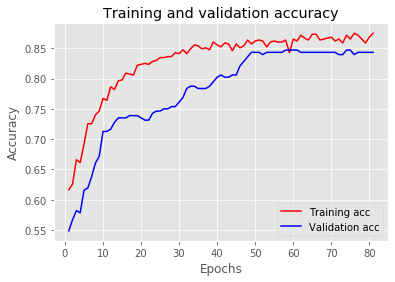

In [151]:
## draw the accuracy graph

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, acc, 'r', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy') 
plt.legend()
plt.show()

In [152]:
## predict on the test data

X_test=df[891:]
results=model.predict(X_test)
len(results)

418/418 [==============================] - 0s 96us/step


418

In [153]:
prediction=[]
for result in results:
    if result >=0.5:
        prediction.append(1) 
    else:
        prediction.append(0)

In [154]:
df_prediction = pd.DataFrame(prediction)

In [155]:
len(df_prediction)

418

In [156]:
test_id = data['PassengerId'][891:].reset_index(drop=True)
test_id

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [157]:
df_prediction = pd.concat([test_id, df_prediction],axis=1)
df_prediction

,PassengerId,0
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [158]:
## convert the dataframe to the kaggle format

df_prediction.index = pd.RangeIndex(start=1, stop=419, step=1)
df_prediction = df_prediction.rename(columns={0:'Survived'})
df_prediction

,PassengerId,Survived
1,892,0
2,893,1
3,894,0
4,895,0
5,896,1
...,...,...
414,1305,0
415,1306,1
416,1307,0
417,1308,0


In [159]:
df_prediction.to_csv('E:/Coding/Projects/Titanic survive prediction/prediction.csv',index=False)